In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [20]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [21]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 49)
        )
        self.decoder = nn.Sequential(
            nn.Linear(49, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
print(model)

Using cpu device
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=49, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [23]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        X = X.reshape(-1, 28*28)
        pred = model(X)
        loss = loss_fn(pred, X)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [25]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.231428  [   64/60000]
loss: 0.066512  [ 6464/60000]
loss: 0.053044  [12864/60000]
loss: 0.054014  [19264/60000]
loss: 0.041925  [25664/60000]
loss: 0.039248  [32064/60000]
loss: 0.033035  [38464/60000]
loss: 0.033695  [44864/60000]
loss: 0.031753  [51264/60000]
loss: 0.029289  [57664/60000]
Epoch 2
-------------------------------
loss: 0.030560  [   64/60000]
loss: 0.029205  [ 6464/60000]
loss: 0.026056  [12864/60000]
loss: 0.027754  [19264/60000]
loss: 0.027127  [25664/60000]
loss: 0.025775  [32064/60000]
loss: 0.022930  [38464/60000]
loss: 0.024183  [44864/60000]
loss: 0.022274  [51264/60000]
loss: 0.022729  [57664/60000]
Epoch 3
-------------------------------
loss: 0.022962  [   64/60000]
loss: 0.020193  [ 6464/60000]
loss: 0.019804  [12864/60000]
loss: 0.022042  [19264/60000]
loss: 0.020823  [25664/60000]
loss: 0.020459  [32064/60000]
loss: 0.019297  [38464/60000]
loss: 0.020017  [44864/60000]
loss: 0.017748  [51264/60000]
loss: 0.01

In [26]:
results = []

for (img, _) in test_dataloader:

  img = img.reshape(-1, 28*28)
  print(img.shape)
  pred = model(img)
  results.append((1, img, pred))
  break

torch.Size([64, 784])


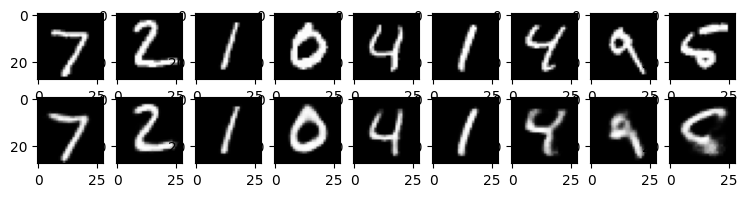

In [27]:
for k in range(0, 1, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = results[k][1].detach().numpy()
    recon = results[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])